In [1]:
import pandas as pd
import numpy as np
import math
import openpyxl
import keras
import random
from matplotlib import pyplot as plt
from matplotlib.pylab import mpl
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras import backend as K
from keras.layers.core import Activation, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
from tensorflow.keras import Input, Model,Sequential
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error 
from keras.layers.core import Dropout
from sklearn import metrics

In [2]:
mpl.rcParams['axes.unicode_minus']=False

In [3]:
#read the data, is this case, I just use 'grav_cocaine' as an example
data=pd.read_excel('opoid.xlsx',usecols = [0,1,2,28,92],nrows = 1320,parse_dates=True)
data.columns = ['year', 'countyfips','state','num_cocaine','oddeath_cocaine']
data

,year,countyfips,state,num_cocaine,oddeath_cocaine
0,2010,21001,KY,9,5
1,2011,21001,KY,6,5
2,2012,21001,KY,5,5
3,2013,21001,KY,8,5
4,2014,21001,KY,10,5
...,...,...,...,...,...
1315,2016,21239,KY,19,5
1316,2017,21239,KY,16,5
1317,2018,21239,KY,23,5
1318,2019,21239,KY,11,5


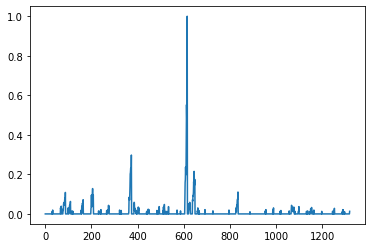

In [4]:
#scaler the data, making them in the range of 0-1
scaler = MinMaxScaler()
data[['oddeath_cocaine']] = scaler.fit_transform(data[['oddeath_cocaine']])
plt.plot(data['oddeath_cocaine'])


In [5]:
#transferring data into 3-dimension data
time_step = 20       #time_step can be changed to such as 10, 20, 30. Different value will result in different outcome
ten_minutes = 1      #value need to predict(after), 1,2,3....

y = [data.iloc[i: i + ten_minutes].loc[:, ['oddeath_cocaine']].to_numpy() for i in range(time_step, len(data) - ten_minutes)]
y = np.array(y).astype(float)
y = np.mean(y, axis=1)
x = [data.iloc[i: i + time_step].loc[:, ['num_cocaine','oddeath_cocaine']].to_numpy() for i in range(len(data) - time_step - ten_minutes)]
x = np.array(x).astype(float)

print('x.shape, y.shape', x.shape, y.shape)

x.shape, y.shape (1299, 20, 1) (1299, 1)


In [6]:
#saparating training and test sets
train_x, val_x, train_y, val_y = x[: 1056], x[1056: ], y[: 1056], y[1056: ]
print('train_x.shape, val_x.shape, train_y.shape, val_y.shape: ', train_x.shape, val_x.shape, train_y.shape, val_y.shape)

train_x.shape, val_x.shape, train_y.shape, val_y.shape:  (1056, 20, 1) (243, 20, 1) (1056, 1) (243, 1)


In [7]:
#setting up early stopper
from tensorflow.keras.callbacks import EarlyStopping
EarlyStopper = EarlyStopping(patience=4, monitor='loss', mode='min', min_delta=1e-5, restore_best_weights=False, verbose=2)

In [8]:
# pso
class PSO:
    def __init__(self, parameters):
        
        self.time = parameters[0]    
        self.pop_size = parameters[1]    
        self.dim = len(parameters[2])     
        self.bound = []                 
        self.bound.append(parameters[2])
        self.bound.append(parameters[3])
        
        self.pop_x = np.zeros((self.pop_size, self.dim))    
        self.pop_v = np.zeros((self.pop_size, self.dim))    
        self.p_best = np.zeros((self.pop_size, self.dim))   
        self.g_best = np.zeros((1, self.dim))   
    
    # 0 gen optimal solution
        temp = -1
        for i in range(self.pop_size):
            for j in range(self.dim):
                self.pop_x[i][j] = random.uniform(self.bound[0][j], self.bound[1][j])
                self.pop_v[i][j] = random.uniform(0, 1)
            self.p_best[i] = self.pop_x[i]      # store the best
            fit = self.fitness(self.p_best[i])
            if fit < temp:
                self.g_best = self.p_best[i]
                temp = fit
 
    def fitness(self, ind_var):
        ind_var=ind_var.flatten()
        a = ind_var[0]
        b = ind_var[1]
        c = ind_var[2]
        e = ind_var[3]
        x1=a.astype(np.int)
        x3=c.astype(np.int)
        print('x1：{}'.format(x1))
        print('x2：{}'.format(ind_var[1]))
        print('x3：{}'.format(x3))
        print('x4：{}'.format(ind_var[3]))
        Input_size = x.shape[2]
        Time_step = x.shape[1]
        Hidden_size = x1
        d = b
        batch_size = x3
        learning_rate = e
        # 1st layer
        lstm = keras.Sequential()
        lstm.add(keras.layers.LSTM(units = Hidden_size, input_shape=(train_x.shape[1], train_x.shape[2])))
        lstm.add(Dropout(d))
        lstm.add(keras.layers.Dense(1))
        #2nd layer (if needed)
        lstm = keras.Sequential()
        lstm.add(keras.layers.LSTM(units = Hidden_size, input_shape=(train_x.shape[1], train_x.shape[2]), return_sequences=True))
        lstm.add(Dropout(d))
        lstm.add(keras.layers.LSTM(Hidden_size))
        lstm.add(Dropout(d))
        lstm.add(keras.layers.Dense(1))
         #3rd layer (if needed)
        lstm = keras.Sequential()
        lstm.add(keras.layers.LSTM(units = Hidden_size, input_shape=(train_x.shape[1], train_x.shape[2]), return_sequences=True))
        lstm.add(Dropout(d))
        lstm.add(keras.layers.LSTM(Hidden_size, return_sequences=True))
        lstm.add(Dropout(d))
        lstm.add(keras.layers.LSTM(Hidden_size))
        lstm.add(Dropout(d))
        lstm.add(keras.layers.Dense(1))
        
        opt = tf.keras.optimizers.Adam(learning_rate = e)
        lstm.compile(optimizer = opt, loss = 'mse')
        lstm.fit(train_x, train_y, epochs = 20, batch_size = x3, callbacks=[EarlyStopper], validation_data = (val_x, val_y))
        predictval=lstm(val_x)    
        print("R2 = ",metrics.r2_score(val_y,predictval)) # R2
        return  metrics.r2_score(val_y,predictval)
    
    #update
    def update_operator(self, pop_size):
        c1 = 2     
        c2 = 2
        w = 0.2    
        for i in range(pop_size):
            # speed
            self.pop_v[i] = w * self.pop_v[i] + c1 * random.uniform(0, 1) * (
                    self.p_best[i] - self.pop_x[i]) + c2 * random.uniform(0, 1) * (self.g_best - self.pop_x[i])
            
            self.pop_x[i] = self.pop_x[i] + self.pop_v[i]
            
            for j in range(self.dim):
                if self.pop_x[i][j] < self.bound[0][j]:
                    self.pop_x[i][j] = self.bound[0][j]
                if self.pop_x[i][j] > self.bound[1][j]:
                    self.pop_x[i][j] = self.bound[1][j]
            # p_best and g_best
            if self.fitness(self.pop_x[i]) > self.fitness(self.p_best[i]):
                self.p_best[i] = self.pop_x[i]
            if self.fitness(self.pop_x[i]) > self.fitness(self.g_best):
                self.g_best = self.pop_x[i]
                
    #alternative update operator, has better optimization outcome without changing w, but takes longer time
#    def update_operator(self, pop_size):
#        c1 = 2     
#        c2 = 2
#        ws = 0.9    
#        we = 0.2    
#        for k in range(self.time):
#            for i in range(pop_size):
#                w=ws-(ws-we)*(k/self.time)        
#                print('w：{}'.format(w))
#                
#                self.pop_v[i] = w * self.pop_v[i] + c1 * random.uniform(0, 1) * (
#                        self.p_best[i] - self.pop_x[i]) + c2 * random.uniform(0, 1) * (self.g_best - self.pop_x[i])
#                
#                self.pop_x[i] = self.pop_x[i] + self.pop_v[i]
#                
#                for j in range(self.dim):
#                    if self.pop_x[i][j] < self.bound[0][j]:
#                        self.pop_x[i][j] = self.bound[0][j]
#                    if self.pop_x[i][j] > self.bound[1][j]:
#                        self.pop_x[i][j] = self.bound[1][j]
#                
#                if self.fitness(self.pop_x[i]) > self.fitness(self.p_best[i]):
#                    self.p_best[i] = self.pop_x[i]
#                if self.fitness(self.pop_x[i]) > self.fitness(self.g_best):
#                    self.g_best = self.pop_x[i]
        
    def main(self):
        popobj = []
        self.ng_best = np.zeros((1, self.dim))
        for gen in range(self.time):
            self.update_operator(self.pop_size)
            popobj.append(self.fitness(self.g_best))
            print('############ Generation {} ############'.format(str(gen)))
            if self.fitness(self.g_best) > self.fitness(self.ng_best):
                self.ng_best = self.g_best.copy()
            print('ng best：{}'.format(self.ng_best))
            print('ng best fitness：{}'.format(self.fitness(self.ng_best)))
        print("---- End of (successful) Searching ----")

        plt.figure()
        fig = plt.gcf()
        fig.set_size_inches(12, 8)
        plt.title(u"Iteration Process")
        plt.xlabel(u"Times", size=14)
        plt.ylabel(u"Adaptability", size=14)
        t = [t for t in range(self.time)]
        plt.plot(t, popobj, color='b', linewidth=2)
        plt.show()

x1：58
x2：0.09270294946521238
x3：54
x4：0.08429051476733274


C:\Users\white\AppData\Local\Temp\ipykernel_21544\4099442937.py:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x1=a.astype(np.int)
C:\Users\white\AppData\Local\Temp\ipykernel_21544\4099442937.py:36: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for addi

Epoch 1/20
20/20 [==============================] - 4s 58ms/step - loss: 0.4525 - val_loss: 0.0015
Epoch 2/20
20/20 [==============================] - 0s 20ms/step - loss: 0.0142 - val_loss: 0.0065
Epoch 3/20
20/20 [==============================] - 0s 20ms/step - loss: 0.0067 - val_loss: 5.3455e-05
Epoch 4/20
20/20 [==============================] - 0s 21ms/step - loss: 0.0045 - val_loss: 4.7610e-05
Epoch 5/20
20/20 [==============================] - 0s 20ms/step - loss: 0.0042 - val_loss: 4.9895e-05
Epoch 6/20
20/20 [==============================] - 0s 20ms/step - loss: 0.0038 - val_loss: 2.3539e-04
Epoch 7/20
20/20 [==============================] - 0s 21ms/step - loss: 0.0037 - val_loss: 3.7080e-04
Epoch 8/20
20/20 [==============================] - 0s 20ms/step - loss: 0.0035 - val_loss: 4.7411e-05
Epoch 9/20
20/20 [==============================] - 0s 23ms/step - loss: 0.0034 - val_loss: 7.5503e-05
Epoch 10/20
20/20 [==============================] - 0s 24ms/step - loss: 0.0031 

C:\Users\white\AppData\Local\Temp\ipykernel_21544\4099442937.py:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x1=a.astype(np.int)
C:\Users\white\AppData\Local\Temp\ipykernel_21544\4099442937.py:36: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for addi

Epoch 1/20
59/59 [==============================] - 4s 26ms/step - loss: 0.2279 - val_loss: 0.0011
Epoch 2/20
59/59 [==============================] - 1s 13ms/step - loss: 0.0037 - val_loss: 7.5869e-05
Epoch 3/20
59/59 [==============================] - 1s 13ms/step - loss: 0.0033 - val_loss: 2.3270e-04
Epoch 4/20
59/59 [==============================] - 1s 13ms/step - loss: 0.0033 - val_loss: 4.5954e-04
Epoch 5/20
59/59 [==============================] - 1s 13ms/step - loss: 0.0029 - val_loss: 2.3905e-04
Epoch 6/20
59/59 [==============================] - 1s 13ms/step - loss: 0.0029 - val_loss: 8.8324e-05
Epoch 7/20
59/59 [==============================] - 1s 13ms/step - loss: 0.0032 - val_loss: 0.0014
Epoch 8/20
59/59 [==============================] - 1s 13ms/step - loss: 0.0032 - val_loss: 1.3116e-04
Epoch 9/20
59/59 [==============================] - 1s 13ms/step - loss: 0.0029 - val_loss: 4.9474e-05
Epoch 10/20
59/59 [==============================] - 1s 13ms/step - loss: 0.0030 

C:\Users\white\AppData\Local\Temp\ipykernel_21544\4099442937.py:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x1=a.astype(np.int)
C:\Users\white\AppData\Local\Temp\ipykernel_21544\4099442937.py:36: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for addi

Epoch 1/20
20/20 [==============================] - 4s 60ms/step - loss: 3.9332 - val_loss: 1.0508
Epoch 2/20
20/20 [==============================] - 0s 21ms/step - loss: 0.4775 - val_loss: 0.0197
Epoch 3/20
20/20 [==============================] - 0s 22ms/step - loss: 0.0762 - val_loss: 0.0169
Epoch 4/20
20/20 [==============================] - 0s 22ms/step - loss: 0.0183 - val_loss: 2.4431e-04
Epoch 5/20
20/20 [==============================] - 0s 22ms/step - loss: 0.0081 - val_loss: 7.5653e-04
Epoch 6/20
20/20 [==============================] - 0s 22ms/step - loss: 0.0042 - val_loss: 7.6193e-04
Epoch 7/20
20/20 [==============================] - 0s 21ms/step - loss: 0.0034 - val_loss: 4.4536e-04
Epoch 8/20
20/20 [==============================] - 0s 21ms/step - loss: 0.0029 - val_loss: 3.9931e-04
Epoch 9/20
20/20 [==============================] - 0s 21ms/step - loss: 0.0032 - val_loss: 0.0011
Epoch 10/20
20/20 [==============================] - 0s 21ms/step - loss: 0.0030 - val_lo

C:\Users\white\AppData\Local\Temp\ipykernel_21544\4099442937.py:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x1=a.astype(np.int)
C:\Users\white\AppData\Local\Temp\ipykernel_21544\4099442937.py:36: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for addi

Epoch 1/20
20/20 [==============================] - 4s 69ms/step - loss: 0.4089 - val_loss: 0.0110
Epoch 2/20
20/20 [==============================] - 1s 27ms/step - loss: 0.0077 - val_loss: 0.0031
Epoch 3/20
20/20 [==============================] - 1s 29ms/step - loss: 0.0040 - val_loss: 2.3620e-04
Epoch 4/20
20/20 [==============================] - 1s 28ms/step - loss: 0.0031 - val_loss: 1.9626e-04
Epoch 5/20
20/20 [==============================] - 1s 29ms/step - loss: 0.0029 - val_loss: 1.9735e-04
Epoch 6/20
20/20 [==============================] - 1s 29ms/step - loss: 0.0029 - val_loss: 1.2716e-04
Epoch 7/20
20/20 [==============================] - 1s 28ms/step - loss: 0.0029 - val_loss: 2.7526e-04
Epoch 8/20
20/20 [==============================] - 1s 28ms/step - loss: 0.0029 - val_loss: 1.2184e-04
Epoch 9/20
20/20 [==============================] - 1s 28ms/step - loss: 0.0028 - val_loss: 5.9302e-04
Epoch 10/20
20/20 [==============================] - 1s 28ms/step - loss: 0.0030 

C:\Users\white\AppData\Local\Temp\ipykernel_21544\4099442937.py:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x1=a.astype(np.int)
C:\Users\white\AppData\Local\Temp\ipykernel_21544\4099442937.py:36: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for addi

Epoch 1/20
20/20 [==============================] - 4s 58ms/step - loss: 0.6856 - val_loss: 0.0432
Epoch 2/20
20/20 [==============================] - 0s 21ms/step - loss: 0.0230 - val_loss: 0.0011
Epoch 3/20
20/20 [==============================] - 0s 21ms/step - loss: 0.0070 - val_loss: 4.8951e-04
Epoch 4/20
20/20 [==============================] - 0s 22ms/step - loss: 0.0044 - val_loss: 6.3172e-05
Epoch 5/20
20/20 [==============================] - 0s 22ms/step - loss: 0.0042 - val_loss: 8.9175e-05
Epoch 6/20
20/20 [==============================] - 0s 22ms/step - loss: 0.0035 - val_loss: 5.7256e-05
Epoch 7/20
20/20 [==============================] - 0s 22ms/step - loss: 0.0036 - val_loss: 2.9128e-04
Epoch 8/20
20/20 [==============================] - 0s 22ms/step - loss: 0.0034 - val_loss: 9.0930e-05
Epoch 9/20
20/20 [==============================] - 0s 22ms/step - loss: 0.0036 - val_loss: 0.0014
Epoch 10/20
20/20 [==============================] - 0s 22ms/step - loss: 0.0034 - va

C:\Users\white\AppData\Local\Temp\ipykernel_21544\4099442937.py:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x1=a.astype(np.int)
C:\Users\white\AppData\Local\Temp\ipykernel_21544\4099442937.py:36: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for addi

Epoch 1/20
20/20 [==============================] - 5s 66ms/step - loss: 1.6573 - val_loss: 0.2640
Epoch 2/20
20/20 [==============================] - 1s 26ms/step - loss: 0.0799 - val_loss: 0.0055
Epoch 3/20
20/20 [==============================] - 1s 26ms/step - loss: 0.0132 - val_loss: 0.0026
Epoch 4/20
20/20 [==============================] - 1s 26ms/step - loss: 0.0049 - val_loss: 2.3232e-04
Epoch 5/20
20/20 [==============================] - 1s 26ms/step - loss: 0.0038 - val_loss: 3.0447e-04
Epoch 6/20
20/20 [==============================] - 1s 26ms/step - loss: 0.0037 - val_loss: 1.0646e-04
Epoch 7/20
20/20 [==============================] - 1s 27ms/step - loss: 0.0035 - val_loss: 1.3527e-04
Epoch 8/20
20/20 [==============================] - 1s 27ms/step - loss: 0.0035 - val_loss: 4.8299e-04
Epoch 9/20
20/20 [==============================] - 1s 27ms/step - loss: 0.0034 - val_loss: 4.3108e-04
Epoch 10/20
20/20 [==============================] - 1s 27ms/step - loss: 0.0036 - va

C:\Users\white\AppData\Local\Temp\ipykernel_21544\4099442937.py:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x1=a.astype(np.int)
C:\Users\white\AppData\Local\Temp\ipykernel_21544\4099442937.py:36: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for addi

Epoch 1/20
40/40 [==============================] - 5s 36ms/step - loss: 1.6891 - val_loss: 0.1140
Epoch 2/20
40/40 [==============================] - 1s 16ms/step - loss: 0.0602 - val_loss: 0.0065
Epoch 3/20
40/40 [==============================] - 1s 16ms/step - loss: 0.0062 - val_loss: 6.1396e-05
Epoch 4/20
40/40 [==============================] - 1s 16ms/step - loss: 0.0035 - val_loss: 6.6592e-04
Epoch 5/20
40/40 [==============================] - 1s 16ms/step - loss: 0.0034 - val_loss: 2.4132e-04
Epoch 6/20
40/40 [==============================] - 1s 16ms/step - loss: 0.0036 - val_loss: 2.8690e-04
Epoch 7/20
40/40 [==============================] - 1s 16ms/step - loss: 0.0041 - val_loss: 0.0022
Epoch 8/20
40/40 [==============================] - 1s 17ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 9/20
40/40 [==============================] - 1s 17ms/step - loss: 0.0044 - val_loss: 4.2011e-05
Epoch 9: early stopping
R2 =  -0.02763044532643022
x1：62
x2：0.03903374812429307
x3：18
x4：

C:\Users\white\AppData\Local\Temp\ipykernel_21544\4099442937.py:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x1=a.astype(np.int)
C:\Users\white\AppData\Local\Temp\ipykernel_21544\4099442937.py:36: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for addi

Epoch 1/20
59/59 [==============================] - 5s 29ms/step - loss: 0.5250 - val_loss: 0.0156
Epoch 2/20
59/59 [==============================] - 1s 16ms/step - loss: 0.0276 - val_loss: 6.9962e-04
Epoch 3/20
59/59 [==============================] - 1s 16ms/step - loss: 0.0076 - val_loss: 4.3042e-05
Epoch 4/20
59/59 [==============================] - 1s 16ms/step - loss: 0.0038 - val_loss: 1.1628e-04
Epoch 5/20
59/59 [==============================] - 1s 16ms/step - loss: 0.0032 - val_loss: 6.6176e-04
Epoch 6/20
59/59 [==============================] - 1s 16ms/step - loss: 0.0036 - val_loss: 0.0022
Epoch 7/20
59/59 [==============================] - 1s 16ms/step - loss: 0.0034 - val_loss: 0.0016
Epoch 8/20
59/59 [==============================] - 1s 16ms/step - loss: 0.0030 - val_loss: 2.3296e-04
Epoch 9/20
59/59 [==============================] - 1s 16ms/step - loss: 0.0031 - val_loss: 8.1661e-05
Epoch 10/20
59/59 [==============================] - 1s 16ms/step - loss: 0.0035 - va

C:\Users\white\AppData\Local\Temp\ipykernel_21544\4099442937.py:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x1=a.astype(np.int)
C:\Users\white\AppData\Local\Temp\ipykernel_21544\4099442937.py:36: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for addi

Epoch 1/20
40/40 [==============================] - 4s 35ms/step - loss: 0.5500 - val_loss: 0.0349
Epoch 2/20
40/40 [==============================] - 1s 16ms/step - loss: 0.0120 - val_loss: 3.1294e-04
Epoch 3/20
40/40 [==============================] - 1s 16ms/step - loss: 0.0032 - val_loss: 4.4994e-05
Epoch 4/20
40/40 [==============================] - 1s 16ms/step - loss: 0.0032 - val_loss: 4.2520e-04
Epoch 5/20
40/40 [==============================] - 1s 16ms/step - loss: 0.0030 - val_loss: 5.2870e-05
Epoch 6/20
40/40 [==============================] - 1s 16ms/step - loss: 0.0031 - val_loss: 9.5955e-05
Epoch 7/20
40/40 [==============================] - 1s 16ms/step - loss: 0.0032 - val_loss: 2.9529e-04
Epoch 8/20
40/40 [==============================] - 1s 16ms/step - loss: 0.0039 - val_loss: 0.0026
Epoch 9/20
40/40 [==============================] - 1s 16ms/step - loss: 0.0043 - val_loss: 0.0012
Epoch 9: early stopping
R2 =  -29.378093720608902
x1：58
x2：0.1
x3：54
x4：0.18573994697

C:\Users\white\AppData\Local\Temp\ipykernel_21544\4099442937.py:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x1=a.astype(np.int)
C:\Users\white\AppData\Local\Temp\ipykernel_21544\4099442937.py:36: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for addi

Epoch 1/20
20/20 [==============================] - 4s 68ms/step - loss: 3.3527 - val_loss: 0.4227
Epoch 2/20
20/20 [==============================] - 1s 32ms/step - loss: 0.2465 - val_loss: 0.0520
Epoch 3/20
20/20 [==============================] - 1s 32ms/step - loss: 0.0434 - val_loss: 0.0196
Epoch 4/20
20/20 [==============================] - 1s 32ms/step - loss: 0.0115 - val_loss: 2.0972e-04
Epoch 5/20
20/20 [==============================] - 1s 33ms/step - loss: 0.0048 - val_loss: 5.0276e-05
Epoch 6/20
20/20 [==============================] - 1s 33ms/step - loss: 0.0037 - val_loss: 5.8457e-05
Epoch 7/20
20/20 [==============================] - 1s 33ms/step - loss: 0.0039 - val_loss: 4.1797e-05
Epoch 8/20
20/20 [==============================] - 1s 33ms/step - loss: 0.0036 - val_loss: 1.9190e-04
Epoch 9/20
20/20 [==============================] - 1s 32ms/step - loss: 0.0036 - val_loss: 5.4428e-04
Epoch 10/20
20/20 [==============================] - 1s 32ms/step - loss: 0.0036 - va

C:\Users\white\AppData\Local\Temp\ipykernel_21544\4099442937.py:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x1=a.astype(np.int)
C:\Users\white\AppData\Local\Temp\ipykernel_21544\4099442937.py:36: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for addi

Epoch 1/20
20/20 [==============================] - 5s 74ms/step - loss: 8.7018 - val_loss: 0.1339
Epoch 2/20
20/20 [==============================] - 1s 37ms/step - loss: 1.0545 - val_loss: 0.5348
Epoch 3/20
20/20 [==============================] - 1s 37ms/step - loss: 0.3067 - val_loss: 0.1379
Epoch 4/20
20/20 [==============================] - 1s 37ms/step - loss: 0.1438 - val_loss: 0.0251
Epoch 5/20
20/20 [==============================] - 1s 37ms/step - loss: 0.0647 - val_loss: 0.0022
Epoch 6/20
20/20 [==============================] - 1s 37ms/step - loss: 0.0249 - val_loss: 0.0047
Epoch 7/20
20/20 [==============================] - 1s 37ms/step - loss: 0.0131 - val_loss: 0.0017
Epoch 8/20
20/20 [==============================] - 1s 37ms/step - loss: 0.0065 - val_loss: 4.5386e-05
Epoch 9/20
20/20 [==============================] - 1s 37ms/step - loss: 0.0045 - val_loss: 8.1785e-04
Epoch 10/20
20/20 [==============================] - 1s 37ms/step - loss: 0.0036 - val_loss: 2.5211e-

C:\Users\white\AppData\Local\Temp\ipykernel_21544\4099442937.py:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x1=a.astype(np.int)
C:\Users\white\AppData\Local\Temp\ipykernel_21544\4099442937.py:36: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for addi

Epoch 1/20
20/20 [==============================] - 4s 70ms/step - loss: 4.1502 - val_loss: 1.2327
Epoch 2/20
20/20 [==============================] - 1s 32ms/step - loss: 0.3248 - val_loss: 0.0895
Epoch 3/20
20/20 [==============================] - 1s 32ms/step - loss: 0.0508 - val_loss: 0.0152
Epoch 4/20
20/20 [==============================] - 1s 32ms/step - loss: 0.0163 - val_loss: 5.6015e-04
Epoch 5/20
20/20 [==============================] - 1s 32ms/step - loss: 0.0064 - val_loss: 8.6065e-04
Epoch 6/20
20/20 [==============================] - 1s 33ms/step - loss: 0.0034 - val_loss: 1.0603e-04
Epoch 7/20
20/20 [==============================] - 1s 33ms/step - loss: 0.0029 - val_loss: 5.7747e-05
Epoch 8/20
20/20 [==============================] - 1s 32ms/step - loss: 0.0030 - val_loss: 1.0247e-04
Epoch 9/20
20/20 [==============================] - 1s 33ms/step - loss: 0.0029 - val_loss: 6.0413e-05
Epoch 10/20
20/20 [==============================] - 1s 32ms/step - loss: 0.0028 - va

C:\Users\white\AppData\Local\Temp\ipykernel_21544\4099442937.py:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x1=a.astype(np.int)
C:\Users\white\AppData\Local\Temp\ipykernel_21544\4099442937.py:36: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for addi

Epoch 1/20
33/33 [==============================] - 3s 29ms/step - loss: 0.0029 - val_loss: 4.6209e-05
Epoch 2/20
33/33 [==============================] - 0s 7ms/step - loss: 0.0029 - val_loss: 4.6209e-05
Epoch 3/20
33/33 [==============================] - 0s 7ms/step - loss: 0.0029 - val_loss: 4.6209e-05
Epoch 4/20
33/33 [==============================] - 0s 7ms/step - loss: 0.0029 - val_loss: 4.6209e-05
Epoch 5/20
33/33 [==============================] - 0s 7ms/step - loss: 0.0029 - val_loss: 4.6209e-05
Epoch 5: early stopping
R2 =  -0.1303122136866588
ng best：[[0. 0. 0. 0.]]
x1：0
x2：0.0
x3：0
x4：0.0


C:\Users\white\AppData\Local\Temp\ipykernel_21544\4099442937.py:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x1=a.astype(np.int)
C:\Users\white\AppData\Local\Temp\ipykernel_21544\4099442937.py:36: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for addi

Epoch 1/20
33/33 [==============================] - 3s 29ms/step - loss: 0.0029 - val_loss: 4.6209e-05
Epoch 2/20
33/33 [==============================] - 0s 7ms/step - loss: 0.0029 - val_loss: 4.6209e-05
Epoch 3/20
33/33 [==============================] - 0s 7ms/step - loss: 0.0029 - val_loss: 4.6209e-05
Epoch 4/20
33/33 [==============================] - 0s 7ms/step - loss: 0.0029 - val_loss: 4.6209e-05
Epoch 5/20
33/33 [==============================] - 0s 7ms/step - loss: 0.0029 - val_loss: 4.6209e-05
Epoch 5: early stopping
R2 =  -0.1303122136866588
ng best fitness：-0.1303122136866588
x1：58
x2：0.1
x3：54
x4：0.2


C:\Users\white\AppData\Local\Temp\ipykernel_21544\4099442937.py:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x1=a.astype(np.int)
C:\Users\white\AppData\Local\Temp\ipykernel_21544\4099442937.py:36: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for addi

Epoch 1/20
20/20 [==============================] - 4s 66ms/step - loss: 2.2760 - val_loss: 0.0107
Epoch 2/20
20/20 [==============================] - 1s 29ms/step - loss: 0.2341 - val_loss: 0.1290
Epoch 3/20
20/20 [==============================] - 1s 29ms/step - loss: 0.0539 - val_loss: 0.0136
Epoch 4/20
20/20 [==============================] - 1s 29ms/step - loss: 0.0116 - val_loss: 9.8029e-04
Epoch 5/20
20/20 [==============================] - 1s 29ms/step - loss: 0.0042 - val_loss: 7.3099e-05
Epoch 6/20
20/20 [==============================] - 1s 29ms/step - loss: 0.0032 - val_loss: 2.1381e-04
Epoch 7/20
20/20 [==============================] - 1s 29ms/step - loss: 0.0034 - val_loss: 0.0024
Epoch 8/20
20/20 [==============================] - 1s 29ms/step - loss: 0.0032 - val_loss: 2.9031e-04
Epoch 9/20
20/20 [==============================] - 1s 29ms/step - loss: 0.0033 - val_loss: 7.7008e-04
Epoch 10/20
20/20 [==============================] - 1s 29ms/step - loss: 0.0031 - val_lo

C:\Users\white\AppData\Local\Temp\ipykernel_21544\4099442937.py:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x1=a.astype(np.int)
C:\Users\white\AppData\Local\Temp\ipykernel_21544\4099442937.py:36: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for addi

Epoch 1/20
20/20 [==============================] - 4s 76ms/step - loss: 1.3559 - val_loss: 0.0129
Epoch 2/20
20/20 [==============================] - 1s 26ms/step - loss: 0.1431 - val_loss: 0.0739
Epoch 3/20
20/20 [==============================] - 1s 26ms/step - loss: 0.0264 - val_loss: 0.0059
Epoch 4/20
20/20 [==============================] - 1s 26ms/step - loss: 0.0065 - val_loss: 8.5759e-05
Epoch 5/20
20/20 [==============================] - 1s 26ms/step - loss: 0.0036 - val_loss: 5.6963e-05
Epoch 6/20
20/20 [==============================] - 1s 26ms/step - loss: 0.0031 - val_loss: 5.1619e-05
Epoch 7/20
20/20 [==============================] - 1s 26ms/step - loss: 0.0037 - val_loss: 0.0016
Epoch 8/20
20/20 [==============================] - 1s 26ms/step - loss: 0.0037 - val_loss: 9.9576e-05
Epoch 9/20
20/20 [==============================] - 1s 26ms/step - loss: 0.0031 - val_loss: 2.6076e-04
Epoch 10/20
20/20 [==============================] - 1s 26ms/step - loss: 0.0033 - val_lo

C:\Users\white\AppData\Local\Temp\ipykernel_21544\4099442937.py:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x1=a.astype(np.int)
C:\Users\white\AppData\Local\Temp\ipykernel_21544\4099442937.py:36: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for addi

Epoch 1/20
20/20 [==============================] - 4s 62ms/step - loss: 1.9507 - val_loss: 0.0164
Epoch 2/20
20/20 [==============================] - 1s 27ms/step - loss: 0.2467 - val_loss: 0.1538
Epoch 3/20
20/20 [==============================] - 1s 27ms/step - loss: 0.0658 - val_loss: 0.0056
Epoch 4/20
20/20 [==============================] - 1s 27ms/step - loss: 0.0156 - val_loss: 0.0104
Epoch 5/20
20/20 [==============================] - 1s 27ms/step - loss: 0.0074 - val_loss: 0.0011
Epoch 6/20
20/20 [==============================] - 1s 27ms/step - loss: 0.0034 - val_loss: 8.0283e-04
Epoch 7/20
20/20 [==============================] - 1s 27ms/step - loss: 0.0041 - val_loss: 8.8998e-04
Epoch 8/20
20/20 [==============================] - 1s 27ms/step - loss: 0.0039 - val_loss: 0.0059
Epoch 9/20
20/20 [==============================] - 1s 27ms/step - loss: 0.0038 - val_loss: 2.5765e-04
Epoch 10/20
20/20 [==============================] - 1s 27ms/step - loss: 0.0039 - val_loss: 1.93

C:\Users\white\AppData\Local\Temp\ipykernel_21544\4099442937.py:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x1=a.astype(np.int)
C:\Users\white\AppData\Local\Temp\ipykernel_21544\4099442937.py:36: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for addi

Epoch 1/20
20/20 [==============================] - 4s 65ms/step - loss: 1.6319 - val_loss: 0.4007
Epoch 2/20
20/20 [==============================] - 1s 28ms/step - loss: 0.1419 - val_loss: 0.0065
Epoch 3/20
20/20 [==============================] - 1s 28ms/step - loss: 0.0249 - val_loss: 4.3373e-04
Epoch 4/20
20/20 [==============================] - 1s 28ms/step - loss: 0.0059 - val_loss: 5.1672e-04
Epoch 5/20
20/20 [==============================] - 1s 29ms/step - loss: 0.0036 - val_loss: 7.2534e-05
Epoch 6/20
20/20 [==============================] - 1s 28ms/step - loss: 0.0034 - val_loss: 4.6766e-05
Epoch 7/20
20/20 [==============================] - 1s 28ms/step - loss: 0.0039 - val_loss: 0.0011
Epoch 8/20
20/20 [==============================] - 1s 28ms/step - loss: 0.0035 - val_loss: 4.1460e-05
Epoch 9/20
20/20 [==============================] - 1s 28ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 10/20
20/20 [==============================] - 1s 28ms/step - loss: 0.0039 - val_lo

C:\Users\white\AppData\Local\Temp\ipykernel_21544\4099442937.py:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x1=a.astype(np.int)
C:\Users\white\AppData\Local\Temp\ipykernel_21544\4099442937.py:36: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for addi

Epoch 1/20
17/17 [==============================] - 4s 78ms/step - loss: 4.1354 - val_loss: 0.0244
Epoch 2/20
17/17 [==============================] - 1s 34ms/step - loss: 0.5667 - val_loss: 0.2419
Epoch 3/20
17/17 [==============================] - 1s 34ms/step - loss: 0.2540 - val_loss: 0.0189
Epoch 4/20
17/17 [==============================] - 1s 34ms/step - loss: 0.1024 - val_loss: 1.4806e-04
Epoch 5/20
17/17 [==============================] - 1s 34ms/step - loss: 0.0436 - val_loss: 0.0011
Epoch 6/20
17/17 [==============================] - 1s 34ms/step - loss: 0.0207 - val_loss: 0.0026
Epoch 7/20
17/17 [==============================] - 1s 34ms/step - loss: 0.0096 - val_loss: 2.8446e-04
Epoch 8/20
17/17 [==============================] - 1s 34ms/step - loss: 0.0045 - val_loss: 1.3521e-04
Epoch 9/20
17/17 [==============================] - 1s 34ms/step - loss: 0.0033 - val_loss: 5.1888e-05
Epoch 10/20
17/17 [==============================] - 1s 34ms/step - loss: 0.0029 - val_loss: 

C:\Users\white\AppData\Local\Temp\ipykernel_21544\4099442937.py:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x1=a.astype(np.int)
C:\Users\white\AppData\Local\Temp\ipykernel_21544\4099442937.py:36: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for addi

Epoch 1/20
40/40 [==============================] - 4s 34ms/step - loss: 2.7636 - val_loss: 0.0105
Epoch 2/20
40/40 [==============================] - 1s 16ms/step - loss: 0.1001 - val_loss: 0.0224
Epoch 3/20
40/40 [==============================] - 1s 16ms/step - loss: 0.0145 - val_loss: 2.3472e-04
Epoch 4/20
40/40 [==============================] - 1s 16ms/step - loss: 0.0042 - val_loss: 9.1249e-04
Epoch 5/20
40/40 [==============================] - 1s 16ms/step - loss: 0.0035 - val_loss: 2.1958e-04
Epoch 6/20
40/40 [==============================] - 1s 16ms/step - loss: 0.0034 - val_loss: 2.3196e-04
Epoch 7/20
40/40 [==============================] - 1s 16ms/step - loss: 0.0034 - val_loss: 5.3393e-05
Epoch 8/20
40/40 [==============================] - 1s 16ms/step - loss: 0.0031 - val_loss: 4.2038e-04
Epoch 9/20
40/40 [==============================] - 1s 16ms/step - loss: 0.0045 - val_loss: 0.0029
Epoch 10/20
40/40 [==============================] - 1s 16ms/step - loss: 0.0035 - va

C:\Users\white\AppData\Local\Temp\ipykernel_21544\4099442937.py:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x1=a.astype(np.int)
C:\Users\white\AppData\Local\Temp\ipykernel_21544\4099442937.py:36: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for addi

Epoch 1/20
17/17 [==============================] - 4s 75ms/step - loss: 4.0010 - val_loss: 0.9074
Epoch 2/20
17/17 [==============================] - 1s 32ms/step - loss: 0.5442 - val_loss: 0.0195
Epoch 3/20
17/17 [==============================] - 1s 33ms/step - loss: 0.0864 - val_loss: 0.0164
Epoch 4/20
17/17 [==============================] - 1s 33ms/step - loss: 0.0180 - val_loss: 0.0069
Epoch 5/20
17/17 [==============================] - 1s 33ms/step - loss: 0.0074 - val_loss: 5.1473e-04
Epoch 6/20
17/17 [==============================] - 1s 33ms/step - loss: 0.0047 - val_loss: 4.3468e-04
Epoch 7/20
17/17 [==============================] - 1s 33ms/step - loss: 0.0033 - val_loss: 5.5883e-05
Epoch 8/20
17/17 [==============================] - 1s 33ms/step - loss: 0.0033 - val_loss: 5.1910e-05
Epoch 9/20
17/17 [==============================] - 1s 33ms/step - loss: 0.0030 - val_loss: 7.3363e-05
Epoch 10/20
17/17 [==============================] - 1s 33ms/step - loss: 0.0031 - val_lo

C:\Users\white\AppData\Local\Temp\ipykernel_21544\4099442937.py:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x1=a.astype(np.int)
C:\Users\white\AppData\Local\Temp\ipykernel_21544\4099442937.py:36: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for addi

Epoch 1/20
20/20 [==============================] - 5s 69ms/step - loss: 3.9950 - val_loss: 1.2968
Epoch 2/20
20/20 [==============================] - 1s 32ms/step - loss: 0.6632 - val_loss: 0.0418
Epoch 3/20
20/20 [==============================] - 1s 32ms/step - loss: 0.0889 - val_loss: 0.0021
Epoch 4/20
20/20 [==============================] - 1s 32ms/step - loss: 0.0343 - val_loss: 4.3582e-04
Epoch 5/20
20/20 [==============================] - 1s 32ms/step - loss: 0.0098 - val_loss: 5.5414e-04
Epoch 6/20
20/20 [==============================] - 1s 32ms/step - loss: 0.0050 - val_loss: 5.3594e-04
Epoch 7/20
20/20 [==============================] - 1s 32ms/step - loss: 0.0036 - val_loss: 4.4922e-05
Epoch 8/20
20/20 [==============================] - 1s 32ms/step - loss: 0.0033 - val_loss: 3.4333e-04
Epoch 9/20
20/20 [==============================] - 1s 32ms/step - loss: 0.0031 - val_loss: 7.9439e-04
Epoch 10/20
20/20 [==============================] - 1s 32ms/step - loss: 0.0030 - va

C:\Users\white\AppData\Local\Temp\ipykernel_21544\4099442937.py:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x1=a.astype(np.int)
C:\Users\white\AppData\Local\Temp\ipykernel_21544\4099442937.py:36: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for addi

Epoch 1/20
17/17 [==============================] - 5s 87ms/step - loss: 4.9725 - val_loss: 2.4620
Epoch 2/20
17/17 [==============================] - 1s 43ms/step - loss: 0.7582 - val_loss: 0.1507
Epoch 3/20
17/17 [==============================] - 1s 43ms/step - loss: 0.1199 - val_loss: 0.0358
Epoch 4/20
17/17 [==============================] - 1s 43ms/step - loss: 0.0303 - val_loss: 0.0032
Epoch 5/20
17/17 [==============================] - 1s 43ms/step - loss: 0.0092 - val_loss: 0.0021
Epoch 6/20
17/17 [==============================] - 1s 44ms/step - loss: 0.0047 - val_loss: 7.7783e-05
Epoch 7/20
17/17 [==============================] - 1s 43ms/step - loss: 0.0034 - val_loss: 4.8984e-05
Epoch 8/20
17/17 [==============================] - 1s 43ms/step - loss: 0.0031 - val_loss: 1.5814e-04
Epoch 9/20
17/17 [==============================] - 1s 43ms/step - loss: 0.0029 - val_loss: 4.4711e-05
Epoch 10/20
17/17 [==============================] - 1s 44ms/step - loss: 0.0030 - val_loss: 

C:\Users\white\AppData\Local\Temp\ipykernel_21544\4099442937.py:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x1=a.astype(np.int)
C:\Users\white\AppData\Local\Temp\ipykernel_21544\4099442937.py:36: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for addi

Epoch 1/20
17/17 [==============================] - 4s 87ms/step - loss: 3.9895 - val_loss: 0.5890
Epoch 2/20
17/17 [==============================] - 1s 35ms/step - loss: 0.5483 - val_loss: 9.3972e-04
Epoch 3/20
17/17 [==============================] - 1s 34ms/step - loss: 0.0893 - val_loss: 0.0013
Epoch 4/20
17/17 [==============================] - 1s 35ms/step - loss: 0.0189 - val_loss: 0.0023
Epoch 5/20
17/17 [==============================] - 1s 34ms/step - loss: 0.0062 - val_loss: 0.0017
Epoch 6/20
17/17 [==============================] - 1s 34ms/step - loss: 0.0038 - val_loss: 8.1797e-05
Epoch 7/20
17/17 [==============================] - 1s 35ms/step - loss: 0.0031 - val_loss: 1.6080e-04
Epoch 8/20
17/17 [==============================] - 1s 35ms/step - loss: 0.0031 - val_loss: 3.1125e-04
Epoch 9/20
17/17 [==============================] - 1s 34ms/step - loss: 0.0030 - val_loss: 4.1308e-05
Epoch 10/20
17/17 [==============================] - 1s 34ms/step - loss: 0.0031 - val_lo

C:\Users\white\AppData\Local\Temp\ipykernel_21544\4099442937.py:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x1=a.astype(np.int)
C:\Users\white\AppData\Local\Temp\ipykernel_21544\4099442937.py:36: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for addi

Epoch 1/20
33/33 [==============================] - 4s 29ms/step - loss: 0.0029 - val_loss: 4.6209e-05
Epoch 2/20
33/33 [==============================] - 0s 7ms/step - loss: 0.0029 - val_loss: 4.6209e-05
Epoch 3/20
33/33 [==============================] - 0s 7ms/step - loss: 0.0029 - val_loss: 4.6209e-05
Epoch 4/20
33/33 [==============================] - 0s 7ms/step - loss: 0.0029 - val_loss: 4.6209e-05
Epoch 5/20
33/33 [==============================] - 0s 7ms/step - loss: 0.0029 - val_loss: 4.6209e-05
Epoch 5: early stopping
R2 =  -0.1303122136866588
ng best：[[0. 0. 0. 0.]]
x1：0
x2：0.0
x3：0
x4：0.0


C:\Users\white\AppData\Local\Temp\ipykernel_21544\4099442937.py:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x1=a.astype(np.int)
C:\Users\white\AppData\Local\Temp\ipykernel_21544\4099442937.py:36: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for addi

Epoch 1/20
33/33 [==============================] - 3s 29ms/step - loss: 0.0029 - val_loss: 4.6209e-05
Epoch 2/20
33/33 [==============================] - 0s 7ms/step - loss: 0.0029 - val_loss: 4.6209e-05
Epoch 3/20
33/33 [==============================] - 0s 7ms/step - loss: 0.0029 - val_loss: 4.6209e-05
Epoch 4/20
33/33 [==============================] - 0s 7ms/step - loss: 0.0029 - val_loss: 4.6209e-05
Epoch 5/20
33/33 [==============================] - 0s 7ms/step - loss: 0.0029 - val_loss: 4.6209e-05
Epoch 5: early stopping
R2 =  -0.1303122136866588
ng best fitness：-0.1303122136866588
x1：55
x2：0.1
x3：64
x4：0.19179824944276944


C:\Users\white\AppData\Local\Temp\ipykernel_21544\4099442937.py:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x1=a.astype(np.int)
C:\Users\white\AppData\Local\Temp\ipykernel_21544\4099442937.py:36: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for addi

Epoch 1/20
17/17 [==============================] - 4s 94ms/step - loss: 2.1163 - val_loss: 0.1600
Epoch 2/20
17/17 [==============================] - 1s 33ms/step - loss: 0.1769 - val_loss: 5.5884e-04
Epoch 3/20
17/17 [==============================] - 1s 33ms/step - loss: 0.0445 - val_loss: 0.0024
Epoch 4/20
17/17 [==============================] - 1s 33ms/step - loss: 0.0108 - val_loss: 0.0018
Epoch 5/20
17/17 [==============================] - 1s 33ms/step - loss: 0.0043 - val_loss: 1.7567e-04
Epoch 6/20
17/17 [==============================] - 1s 33ms/step - loss: 0.0038 - val_loss: 2.9530e-04
Epoch 7/20
17/17 [==============================] - 1s 33ms/step - loss: 0.0035 - val_loss: 0.0021
Epoch 8/20
17/17 [==============================] - 1s 33ms/step - loss: 0.0042 - val_loss: 1.6919e-04
Epoch 9/20
17/17 [==============================] - 1s 33ms/step - loss: 0.0034 - val_loss: 4.4350e-04
Epoch 10/20
17/17 [==============================] - 1s 33ms/step - loss: 0.0060 - val_lo

C:\Users\white\AppData\Local\Temp\ipykernel_21544\4099442937.py:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x1=a.astype(np.int)
C:\Users\white\AppData\Local\Temp\ipykernel_21544\4099442937.py:36: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for addi

Epoch 1/20
20/20 [==============================] - 4s 70ms/step - loss: 1.9955 - val_loss: 0.8284
Epoch 2/20
20/20 [==============================] - 1s 33ms/step - loss: 0.2345 - val_loss: 0.0509
Epoch 3/20
20/20 [==============================] - 1s 32ms/step - loss: 0.0317 - val_loss: 0.0097
Epoch 4/20
20/20 [==============================] - 1s 32ms/step - loss: 0.0079 - val_loss: 2.1370e-04
Epoch 5/20
20/20 [==============================] - 1s 32ms/step - loss: 0.0037 - val_loss: 1.7462e-04
Epoch 6/20
20/20 [==============================] - 1s 32ms/step - loss: 0.0030 - val_loss: 4.4263e-05
Epoch 7/20
20/20 [==============================] - 1s 32ms/step - loss: 0.0031 - val_loss: 5.7433e-05
Epoch 8/20
20/20 [==============================] - 1s 32ms/step - loss: 0.0028 - val_loss: 8.8071e-05
Epoch 9/20
20/20 [==============================] - 1s 32ms/step - loss: 0.0029 - val_loss: 9.2901e-05
Epoch 10/20
20/20 [==============================] - 1s 32ms/step - loss: 0.0031 - va

C:\Users\white\AppData\Local\Temp\ipykernel_21544\4099442937.py:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x1=a.astype(np.int)
C:\Users\white\AppData\Local\Temp\ipykernel_21544\4099442937.py:36: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for addi

Epoch 1/20
17/17 [==============================] - 4s 76ms/step - loss: 3.2604 - val_loss: 0.7215
Epoch 2/20
17/17 [==============================] - 1s 34ms/step - loss: 0.5969 - val_loss: 0.1301
Epoch 3/20
17/17 [==============================] - 1s 34ms/step - loss: 0.0833 - val_loss: 0.0595
Epoch 4/20
17/17 [==============================] - 1s 34ms/step - loss: 0.0215 - val_loss: 0.0131
Epoch 5/20
17/17 [==============================] - 1s 34ms/step - loss: 0.0063 - val_loss: 8.8409e-04
Epoch 6/20
17/17 [==============================] - 1s 34ms/step - loss: 0.0034 - val_loss: 1.6803e-04
Epoch 7/20
17/17 [==============================] - 1s 34ms/step - loss: 0.0029 - val_loss: 3.0264e-04
Epoch 8/20
17/17 [==============================] - 1s 34ms/step - loss: 0.0029 - val_loss: 6.8822e-04
Epoch 9/20
17/17 [==============================] - 1s 34ms/step - loss: 0.0029 - val_loss: 5.9970e-05
Epoch 10/20
17/17 [==============================] - 1s 34ms/step - loss: 0.0029 - val_lo

C:\Users\white\AppData\Local\Temp\ipykernel_21544\4099442937.py:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x1=a.astype(np.int)
C:\Users\white\AppData\Local\Temp\ipykernel_21544\4099442937.py:36: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for addi

Epoch 1/20
17/17 [==============================] - 5s 85ms/step - loss: 5.8267 - val_loss: 0.0102
Epoch 2/20
17/17 [==============================] - 1s 41ms/step - loss: 0.8018 - val_loss: 0.3460
Epoch 3/20
17/17 [==============================] - 1s 41ms/step - loss: 0.3453 - val_loss: 8.7757e-04
Epoch 4/20
17/17 [==============================] - 1s 42ms/step - loss: 0.1930 - val_loss: 2.5671e-04
Epoch 5/20
17/17 [==============================] - 1s 41ms/step - loss: 0.0909 - val_loss: 0.0035
Epoch 6/20
17/17 [==============================] - 1s 41ms/step - loss: 0.0347 - val_loss: 6.8572e-04
Epoch 7/20
17/17 [==============================] - 1s 42ms/step - loss: 0.0149 - val_loss: 0.0015
Epoch 8/20
17/17 [==============================] - 1s 41ms/step - loss: 0.0062 - val_loss: 2.3327e-04
Epoch 9/20
17/17 [==============================] - 1s 41ms/step - loss: 0.0039 - val_loss: 0.0017
Epoch 10/20
17/17 [==============================] - 1s 41ms/step - loss: 0.0034 - val_loss: 

C:\Users\white\AppData\Local\Temp\ipykernel_21544\4099442937.py:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x1=a.astype(np.int)
C:\Users\white\AppData\Local\Temp\ipykernel_21544\4099442937.py:36: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for addi

Epoch 1/20
40/40 [==============================] - 5s 43ms/step - loss: 0.2901 - val_loss: 5.0828e-04
Epoch 2/20
40/40 [==============================] - 1s 20ms/step - loss: 0.0071 - val_loss: 2.5036e-04
Epoch 3/20
40/40 [==============================] - 1s 19ms/step - loss: 0.0045 - val_loss: 0.0011
Epoch 4/20
40/40 [==============================] - 1s 20ms/step - loss: 0.0049 - val_loss: 0.0020
Epoch 5/20
40/40 [==============================] - 1s 20ms/step - loss: 0.0037 - val_loss: 5.4706e-04
Epoch 6/20
40/40 [==============================] - 1s 20ms/step - loss: 0.0035 - val_loss: 0.0022
Epoch 7/20
40/40 [==============================] - 1s 20ms/step - loss: 0.0036 - val_loss: 0.0014
Epoch 8/20
40/40 [==============================] - 1s 20ms/step - loss: 0.0037 - val_loss: 4.2683e-04
Epoch 9/20
40/40 [==============================] - 1s 20ms/step - loss: 0.0037 - val_loss: 1.1427e-04
Epoch 10/20
40/40 [==============================] - 1s 20ms/step - loss: 0.0039 - val_lo

C:\Users\white\AppData\Local\Temp\ipykernel_21544\4099442937.py:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x1=a.astype(np.int)
C:\Users\white\AppData\Local\Temp\ipykernel_21544\4099442937.py:36: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for addi

Epoch 1/20
40/40 [==============================] - 4s 38ms/step - loss: 1.0184 - val_loss: 0.0017
Epoch 2/20
40/40 [==============================] - 1s 21ms/step - loss: 0.0275 - val_loss: 0.0042
Epoch 3/20
40/40 [==============================] - 1s 21ms/step - loss: 0.0042 - val_loss: 0.0019
Epoch 4/20
40/40 [==============================] - 1s 21ms/step - loss: 0.0035 - val_loss: 1.2924e-04
Epoch 5/20
40/40 [==============================] - 1s 21ms/step - loss: 0.0036 - val_loss: 0.0065
Epoch 6/20
40/40 [==============================] - 1s 20ms/step - loss: 0.0066 - val_loss: 0.0010
Epoch 7/20
40/40 [==============================] - 1s 21ms/step - loss: 0.0033 - val_loss: 5.6825e-04
Epoch 8/20
40/40 [==============================] - 1s 21ms/step - loss: 0.0041 - val_loss: 0.0011
Epoch 9/20
40/40 [==============================] - 1s 21ms/step - loss: 0.0037 - val_loss: 4.8932e-04
Epoch 10/20
40/40 [==============================] - 1s 21ms/step - loss: 0.0041 - val_loss: 0.00

C:\Users\white\AppData\Local\Temp\ipykernel_21544\4099442937.py:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x1=a.astype(np.int)
C:\Users\white\AppData\Local\Temp\ipykernel_21544\4099442937.py:36: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for addi

Epoch 1/20
40/40 [==============================] - 5s 38ms/step - loss: 3.0211 - val_loss: 0.0346
Epoch 2/20
40/40 [==============================] - 1s 21ms/step - loss: 0.1959 - val_loss: 0.0363
Epoch 3/20
40/40 [==============================] - 1s 21ms/step - loss: 0.0319 - val_loss: 3.6922e-04
Epoch 4/20
40/40 [==============================] - 1s 21ms/step - loss: 0.0055 - val_loss: 0.0012
Epoch 5/20
40/40 [==============================] - 1s 21ms/step - loss: 0.0031 - val_loss: 4.3776e-05
Epoch 6/20
40/40 [==============================] - 1s 21ms/step - loss: 0.0032 - val_loss: 2.3712e-04
Epoch 7/20
40/40 [==============================] - 1s 21ms/step - loss: 0.0034 - val_loss: 5.4248e-05
Epoch 8/20
40/40 [==============================] - 1s 21ms/step - loss: 0.0038 - val_loss: 1.6895e-04
Epoch 9/20
40/40 [==============================] - 1s 21ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 9: early stopping
R2 =  -89.54545830064892
x1：55
x2：0.1
x3：64
x4：0.1917982494427694

C:\Users\white\AppData\Local\Temp\ipykernel_21544\4099442937.py:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x1=a.astype(np.int)
C:\Users\white\AppData\Local\Temp\ipykernel_21544\4099442937.py:36: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for addi

Epoch 1/20
17/17 [==============================] - 4s 77ms/step - loss: 1.9752 - val_loss: 0.7333
Epoch 2/20
17/17 [==============================] - 1s 33ms/step - loss: 0.4045 - val_loss: 0.0437
Epoch 3/20
17/17 [==============================] - 1s 34ms/step - loss: 0.1080 - val_loss: 0.0299
Epoch 4/20
17/17 [==============================] - 1s 34ms/step - loss: 0.0279 - val_loss: 0.0038
Epoch 5/20
17/17 [==============================] - 1s 34ms/step - loss: 0.0074 - val_loss: 0.0023
Epoch 6/20
17/17 [==============================] - 1s 34ms/step - loss: 0.0039 - val_loss: 4.3176e-04
Epoch 7/20
17/17 [==============================] - 1s 34ms/step - loss: 0.0035 - val_loss: 6.2283e-04
Epoch 8/20
17/17 [==============================] - 1s 34ms/step - loss: 0.0032 - val_loss: 1.7252e-04
Epoch 9/20
17/17 [==============================] - 1s 34ms/step - loss: 0.0031 - val_loss: 4.3557e-05
Epoch 10/20
17/17 [==============================] - 1s 34ms/step - loss: 0.0031 - val_loss: 

C:\Users\white\AppData\Local\Temp\ipykernel_21544\4099442937.py:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x1=a.astype(np.int)
C:\Users\white\AppData\Local\Temp\ipykernel_21544\4099442937.py:36: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for addi

Epoch 1/20
17/17 [==============================] - 4s 81ms/step - loss: 1.6641 - val_loss: 0.0352
Epoch 2/20
17/17 [==============================] - 1s 37ms/step - loss: 0.2034 - val_loss: 0.1510
Epoch 3/20
17/17 [==============================] - 1s 38ms/step - loss: 0.0444 - val_loss: 0.0116
Epoch 4/20
17/17 [==============================] - 1s 38ms/step - loss: 0.0104 - val_loss: 0.0028
Epoch 5/20
17/17 [==============================] - 1s 37ms/step - loss: 0.0050 - val_loss: 0.0023
Epoch 6/20
17/17 [==============================] - 1s 38ms/step - loss: 0.0036 - val_loss: 6.9779e-05
Epoch 7/20
17/17 [==============================] - 1s 38ms/step - loss: 0.0032 - val_loss: 5.0813e-04
Epoch 8/20
17/17 [==============================] - 1s 38ms/step - loss: 0.0030 - val_loss: 6.9315e-04
Epoch 9/20
17/17 [==============================] - 1s 38ms/step - loss: 0.0030 - val_loss: 9.6874e-04
Epoch 10/20
17/17 [==============================] - 1s 37ms/step - loss: 0.0036 - val_loss: 

C:\Users\white\AppData\Local\Temp\ipykernel_21544\4099442937.py:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x1=a.astype(np.int)
C:\Users\white\AppData\Local\Temp\ipykernel_21544\4099442937.py:36: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for addi

Epoch 1/20
17/17 [==============================] - 4s 75ms/step - loss: 4.3769 - val_loss: 0.9520
Epoch 2/20
17/17 [==============================] - 0s 28ms/step - loss: 0.7188 - val_loss: 0.0484
Epoch 3/20
17/17 [==============================] - 0s 28ms/step - loss: 0.1702 - val_loss: 0.0346
Epoch 4/20
17/17 [==============================] - 0s 27ms/step - loss: 0.0697 - val_loss: 2.1667e-04
Epoch 5/20
17/17 [==============================] - 0s 28ms/step - loss: 0.0266 - val_loss: 6.2189e-04
Epoch 6/20
17/17 [==============================] - 0s 28ms/step - loss: 0.0102 - val_loss: 4.8595e-05
Epoch 7/20
17/17 [==============================] - 0s 28ms/step - loss: 0.0050 - val_loss: 1.8817e-04
Epoch 8/20
17/17 [==============================] - 0s 28ms/step - loss: 0.0039 - val_loss: 1.5910e-04
Epoch 9/20
17/17 [==============================] - 0s 28ms/step - loss: 0.0033 - val_loss: 9.3796e-04
Epoch 10/20
17/17 [==============================] - 0s 28ms/step - loss: 0.0034 - va

C:\Users\white\AppData\Local\Temp\ipykernel_21544\4099442937.py:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x1=a.astype(np.int)
C:\Users\white\AppData\Local\Temp\ipykernel_21544\4099442937.py:36: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for addi

Epoch 1/20
33/33 [==============================] - 3s 29ms/step - loss: 0.0029 - val_loss: 4.6209e-05
Epoch 2/20
33/33 [==============================] - 0s 7ms/step - loss: 0.0029 - val_loss: 4.6209e-05
Epoch 3/20
33/33 [==============================] - 0s 7ms/step - loss: 0.0029 - val_loss: 4.6209e-05
Epoch 4/20
33/33 [==============================] - 0s 7ms/step - loss: 0.0029 - val_loss: 4.6209e-05
Epoch 5/20
33/33 [==============================] - 0s 7ms/step - loss: 0.0029 - val_loss: 4.6209e-05
Epoch 5: early stopping
R2 =  -0.1303122136866588
ng best：[[0. 0. 0. 0.]]
x1：0
x2：0.0
x3：0
x4：0.0


C:\Users\white\AppData\Local\Temp\ipykernel_21544\4099442937.py:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x1=a.astype(np.int)
C:\Users\white\AppData\Local\Temp\ipykernel_21544\4099442937.py:36: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for addi

Epoch 1/20
33/33 [==============================] - 3s 29ms/step - loss: 0.0029 - val_loss: 4.6209e-05
Epoch 2/20
33/33 [==============================] - 0s 7ms/step - loss: 0.0029 - val_loss: 4.6209e-05
Epoch 3/20
33/33 [==============================] - 0s 7ms/step - loss: 0.0029 - val_loss: 4.6209e-05
Epoch 4/20
33/33 [==============================] - 0s 7ms/step - loss: 0.0029 - val_loss: 4.6209e-05
Epoch 5/20
33/33 [==============================] - 0s 7ms/step - loss: 0.0029 - val_loss: 4.6209e-05
Epoch 5: early stopping
R2 =  -0.1303122136866588
ng best fitness：-0.1303122136866588
---- End of (successful) Searching ----


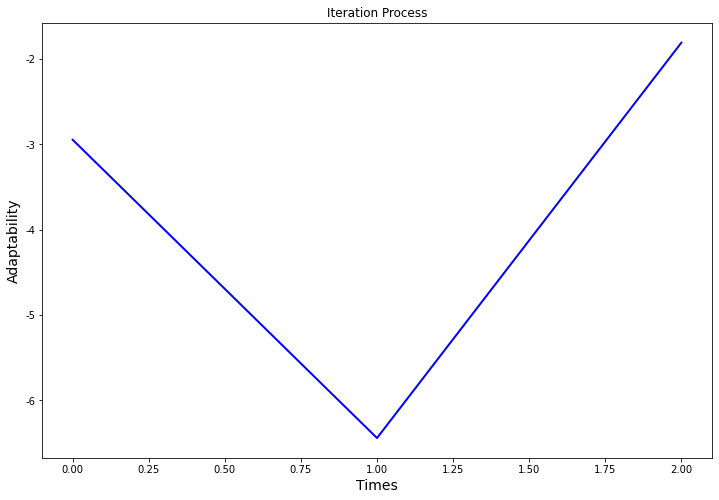

In [9]:
if __name__ == '__main__':
    time = 3                             #longer the time, more accuracy
    popsize = 2                         #the more the popsize, more accuracy
    #hidden_size, dropout, Batch_size, learning_rate
    low = [32, 0, 12, 0.0001]         #lowest value of hidden_size, dropout, Batch_size, learning_rate
    up = [128, 0.1, 64, 0.2]          #max value of hidden_size, dropout, Batch_size, learning_rate
    parameters = [time, popsize, low, up]
    
    pso = PSO(parameters)
    pso.main()
# runing this cell takes longer time depends on time and popsize.

In [111]:
Hidden_size =58
d = 0
batch_size = 41
learning_rate = 0.09
lstm = keras.Sequential()
lstm.add(keras.layers.LSTM(units = Hidden_size, input_shape=(train_x.shape[1], train_x.shape[2])))
lstm.add(Dropout(d))
lstm.add(keras.layers.Dense(1))
opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)
lstm.compile(optimizer = opt, loss = 'mse')
history = lstm.fit(train_x, train_y, epochs = 20, batch_size = batch_size, callbacks=[EarlyStopper], validation_data = (val_x, val_y))

Epoch 1/20
26/26 [==============================] - 1s 18ms/step - loss: 0.3369 - val_loss: 0.0117
Epoch 2/20
26/26 [==============================] - 0s 7ms/step - loss: 0.0108 - val_loss: 0.0033
Epoch 3/20
26/26 [==============================] - 0s 7ms/step - loss: 0.0031 - val_loss: 8.6981e-05
Epoch 4/20
26/26 [==============================] - 0s 7ms/step - loss: 0.0027 - val_loss: 6.0070e-05
Epoch 5/20
26/26 [==============================] - 0s 7ms/step - loss: 0.0026 - val_loss: 2.5450e-04
Epoch 6/20
26/26 [==============================] - 0s 7ms/step - loss: 0.0025 - val_loss: 4.3024e-05
Epoch 7/20
26/26 [==============================] - 0s 7ms/step - loss: 0.0023 - val_loss: 1.0528e-04
Epoch 8/20
26/26 [==============================] - 0s 7ms/step - loss: 0.0022 - val_loss: 3.6440e-05
Epoch 9/20
26/26 [==============================] - 0s 7ms/step - loss: 0.0019 - val_loss: 6.0274e-04
Epoch 10/20
26/26 [==============================] - 0s 7ms/step - loss: 0.0017 - val_los

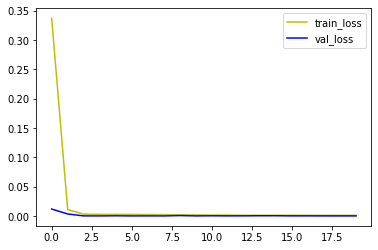

In [112]:
#plot the loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(train_loss[:], 'y', label='train_loss')
plt.plot(val_loss[:], 'b', label='val_loss')
plt.legend()
plt.show()

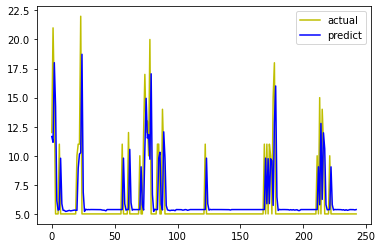

mse: 8.529716366967806 
rmse: 2.920567815848111 
nse: 0.01859490293625954 
mae: 1.4764751330202008 
mape: 0.21042914271767468


In [113]:
y_hat_reverse = scaler.inverse_transform(lstm(val_x)).reshape(-1, 1)
y_reverse = scaler.inverse_transform(val_y)                           
plt.plot(y_reverse[:], 'y', label='actual')
plt.plot(y_hat_reverse[:], 'b', label='predict')
plt.legend()
plt.show()

mse = np.mean((y_reverse - y_hat_reverse) ** 2)
rmse = mse ** 0.5
nse = 1 - (np.sum((y_reverse - y_hat_reverse) ** 2) / np.sum((y_reverse - np.mean(y_hat_reverse)) ** 2))
mae = np.mean(np.abs(y_reverse - y_hat_reverse))
mape = np.mean(np.abs((y_reverse - y_hat_reverse) / y_reverse))
print('mse:', mse, '\nrmse:', rmse, '\nnse:', nse, '\nmae:', mae, '\nmape:', mape)